# Islamophhobia Detection with mBERT using Keras and TensorFlow 2



In [1]:
!nvidia-smi

Fri Sep 18 14:42:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 43kB/s 


In [3]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [4]:
!pip install tqdm

In [5]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=188bd8fa11382544ee27b646ab3d6f4e10501107d85175f8f638c66ffe2ee4e4
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=74a71a4364127347e47d6a47f04b113f57f37874ea757b8aaa6423c836c990d7
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=2602d5c6642d60c1913139ce269ef12ec16a2ee06f2d0f04703f9d658aa88f0e
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
!pip install googletrans

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 962kB 8.2MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=97960e4214c0e595bd2be0c085c9d065ff7e145921f5e8a3ef78d81a7d036be4
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=8ae341fb96a5d11ca8c1534d89207589d1e7bd9148cb5ac6f87119def30c9d87
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.9MB/s 


In [8]:
!pip install googletrans

In [9]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator
translator = Translator()

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [10]:
# English dataset
!gdown --id 1XRgPYGmM5I8KnrJFOEDCaRnvD4rbWrqA --output data-task2.csv

Downloading...
From: https://drive.google.com/uc?id=1XRgPYGmM5I8KnrJFOEDCaRnvD4rbWrqA
To: /content/data-task2.csv
100% 815k/815k [00:00<00:00, 53.8MB/s]


In [11]:
orig_df = pd.read_csv('data-task2.csv', 
                   delimiter=',')
orig_df.columns = ['Text', 'Label']
orig_df.head(15)
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [12]:
orig_df.Text[3]


"'@ParZevil Plymouth Cricket. THREE transmissions."

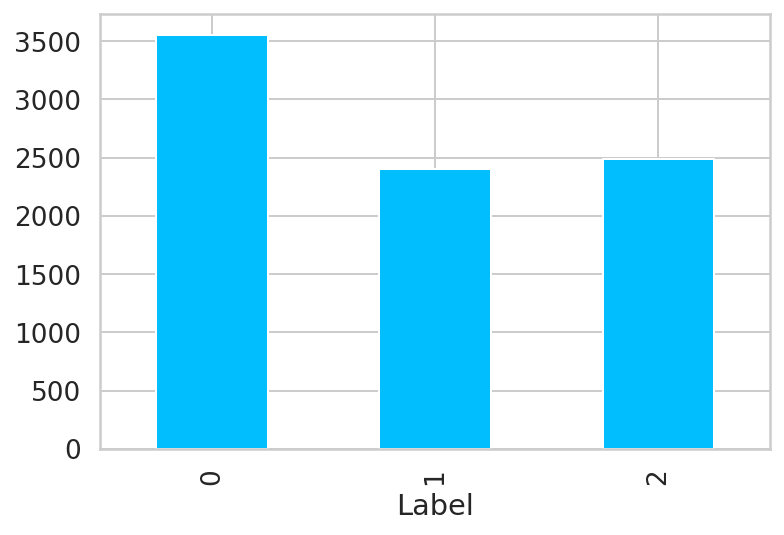

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
orig_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [14]:


# For entire dataset sentences for each labels 
orig_df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

In [15]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [16]:
new_text, new_label = balanceClasses(orig_df['Text'], orig_df['Label'])

In [17]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Text']
data_df['Label'] = new_label
data_df = pd.concat([orig_df, data_df])

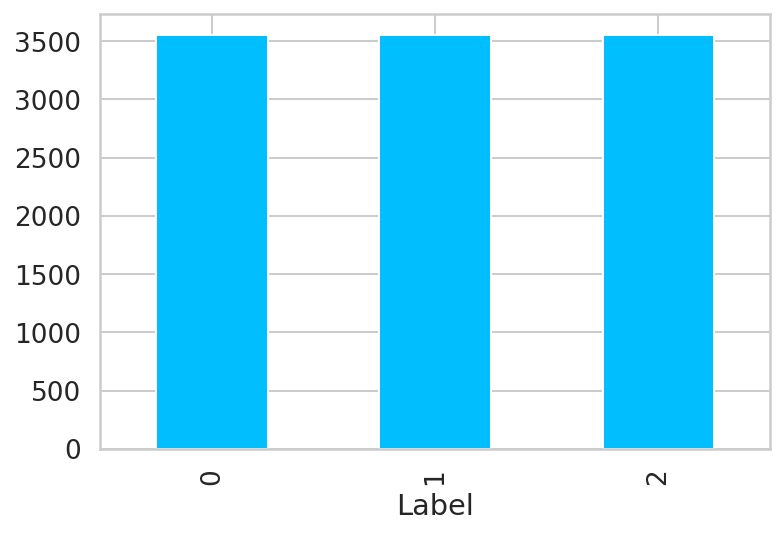

In [18]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [19]:
df = data_df

In [20]:
df.Label.value_counts()

0    3555
2    3554
1    3554
Name: Label, dtype: int64

In [21]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'@OpIndia_com @myogiadityanath pls order encou...,2
1,'@hollandcourtney @RashidaTlaib Ohhhhh letâ€™s...,2
2,"""HAPPY HIJRAH TO ALL MUSLIM BROTHER'S &amp SI...",1
3,"'WizComic official blog: ""Cricket Boy"" Introdu...",0
4,'Fuck you all radical Islamist you are a threa...,2
...,...,...
10658,'emilee and I cried over a cricket today and i...,0
10659,'Happy new Islamic year to everyone- 1st Muhar...,1
10660,'@chedetofficial Elephant walks DOGs bark. Ke...,2
10661,'Training sessions in Sri Lanka to hold sway i...,0


Data Preprocessing

In [22]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [23]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [24]:
df = df[df.Text != '']

In [25]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [26]:
df.head()

,Text,Label
0,OpIndia com myogiadityanath pls order encount...,2
1,hollandcourtney RashidaTlaib Ohhhhh let s rid...,2
2,HAPPY HIJRAH TO ALL MUSLIM BROTHER S amp SIST...,1
3,WizComic official blog : Cricket Boy Introduc...,0
4,Fuck you all radical Islamist you are a threa...,2


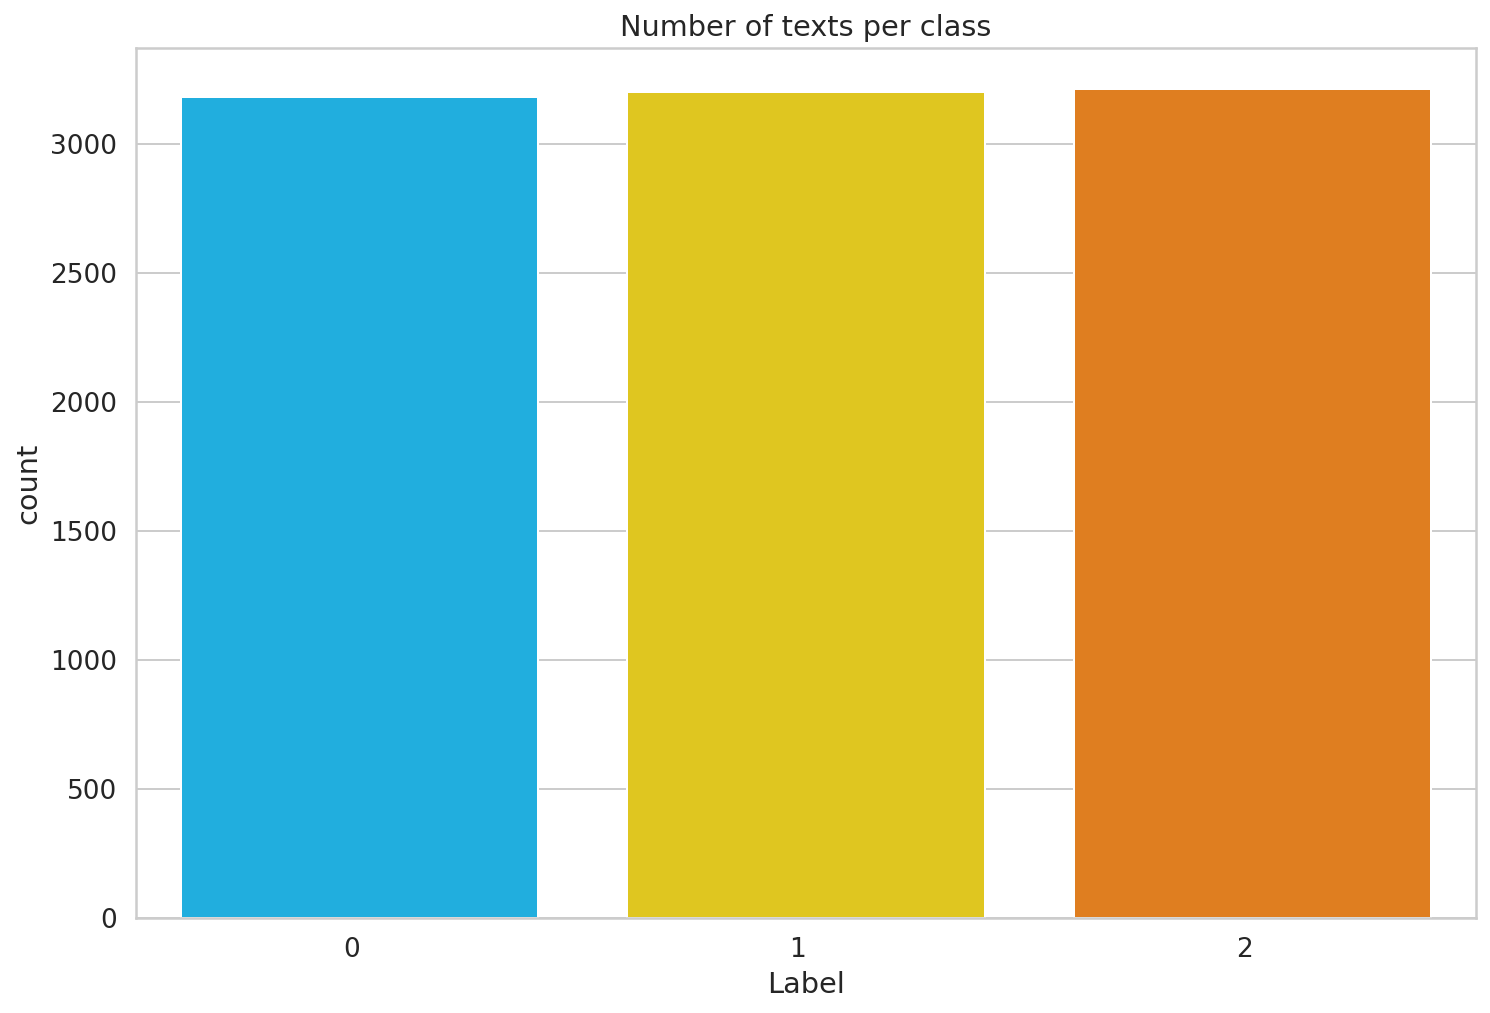

In [27]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right');

# Islamophhobia Detection with mBERT


In [28]:
!gdown --id 1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a --output multi_cased_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a
To: /content/multi_cased_L-12_H-768_A-12.zip
663MB [00:10, 64.6MB/s]


In [29]:
!unzip multi_cased_L-12_H-768_A-12

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [30]:
os.makedirs("model", exist_ok=True)

In [31]:
!mv multi_cased_L-12_H-768_A-12/ model

In [32]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [33]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [34]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [35]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [36]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

9596it [00:04, 2239.33it/s]
1067it [00:00, 2237.70it/s]


max seq_len 393


In [37]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f265dae8358> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [38]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [39]:


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=5
)

Epoch 1/5
270/270 [==============================] - 161s 595ms/step - loss: 0.7250 - acc: 0.8162 - val_loss: 0.6267 - val_acc: 0.9240
Epoch 2/5
270/270 [==============================] - 157s 582ms/step - loss: 0.6122 - acc: 0.9398 - val_loss: 0.6098 - val_acc: 0.9396
Epoch 3/5
270/270 [==============================] - 157s 582ms/step - loss: 0.6021 - acc: 0.9488 - val_loss: 0.5926 - val_acc: 0.9583
Epoch 4/5
270/270 [==============================] - 157s 582ms/step - loss: 0.5977 - acc: 0.9533 - val_loss: 0.6020 - val_acc: 0.9479
Epoch 5/5
270/270 [==============================] - 157s 583ms/step - loss: 0.5933 - acc: 0.9577 - val_loss: 0.5964 - val_acc: 0.9542


## Evaluation

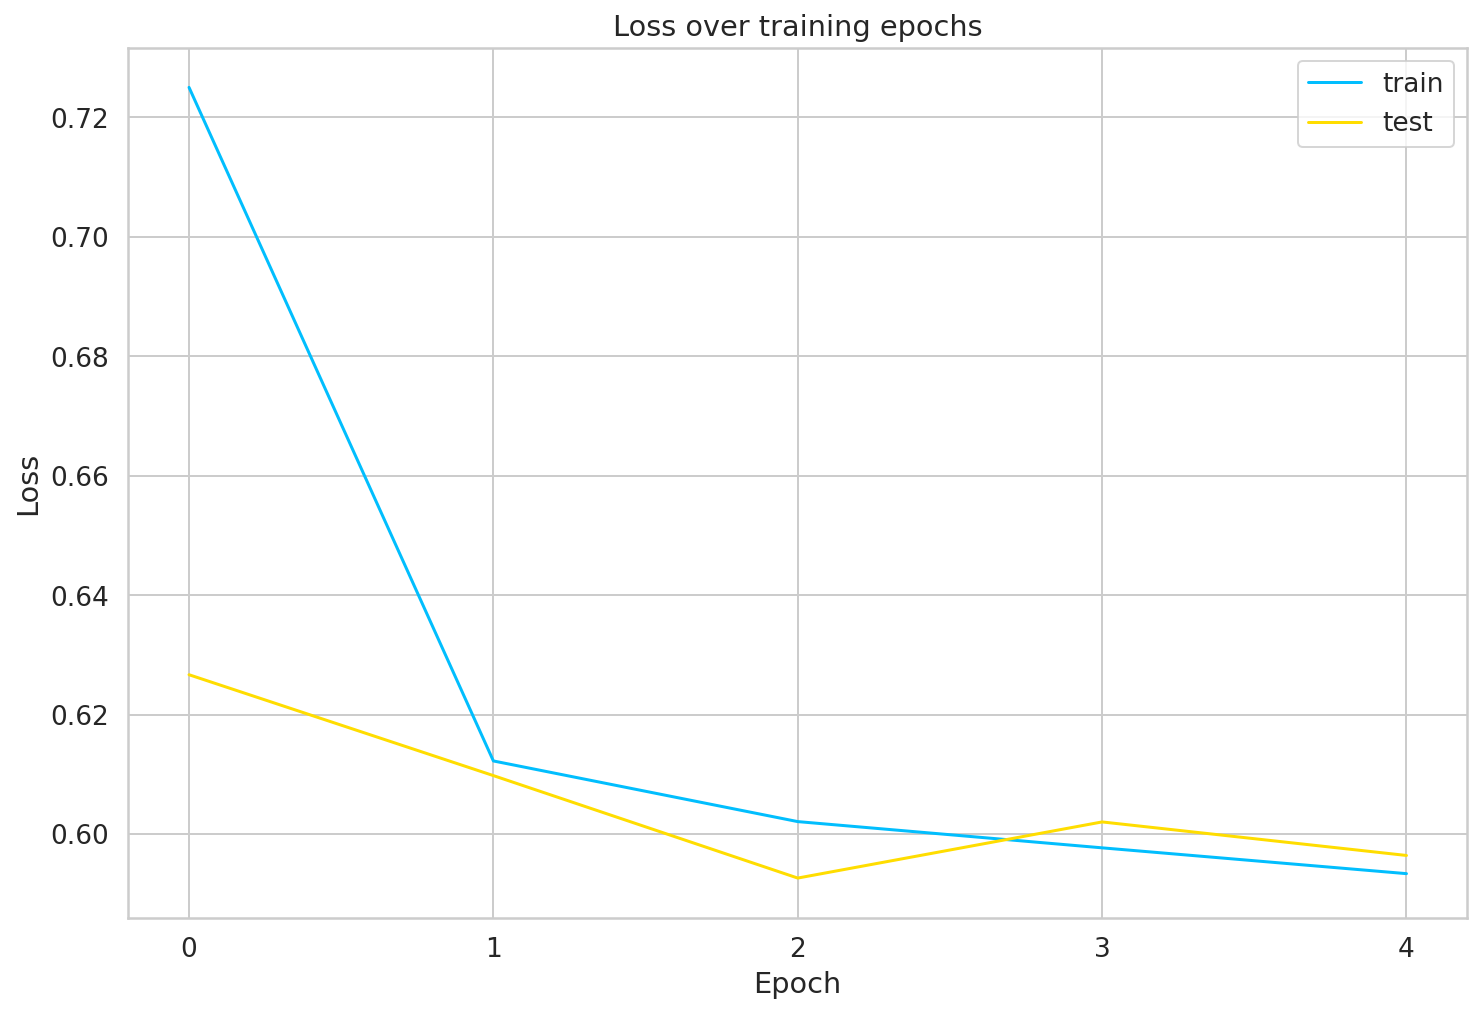

In [40]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

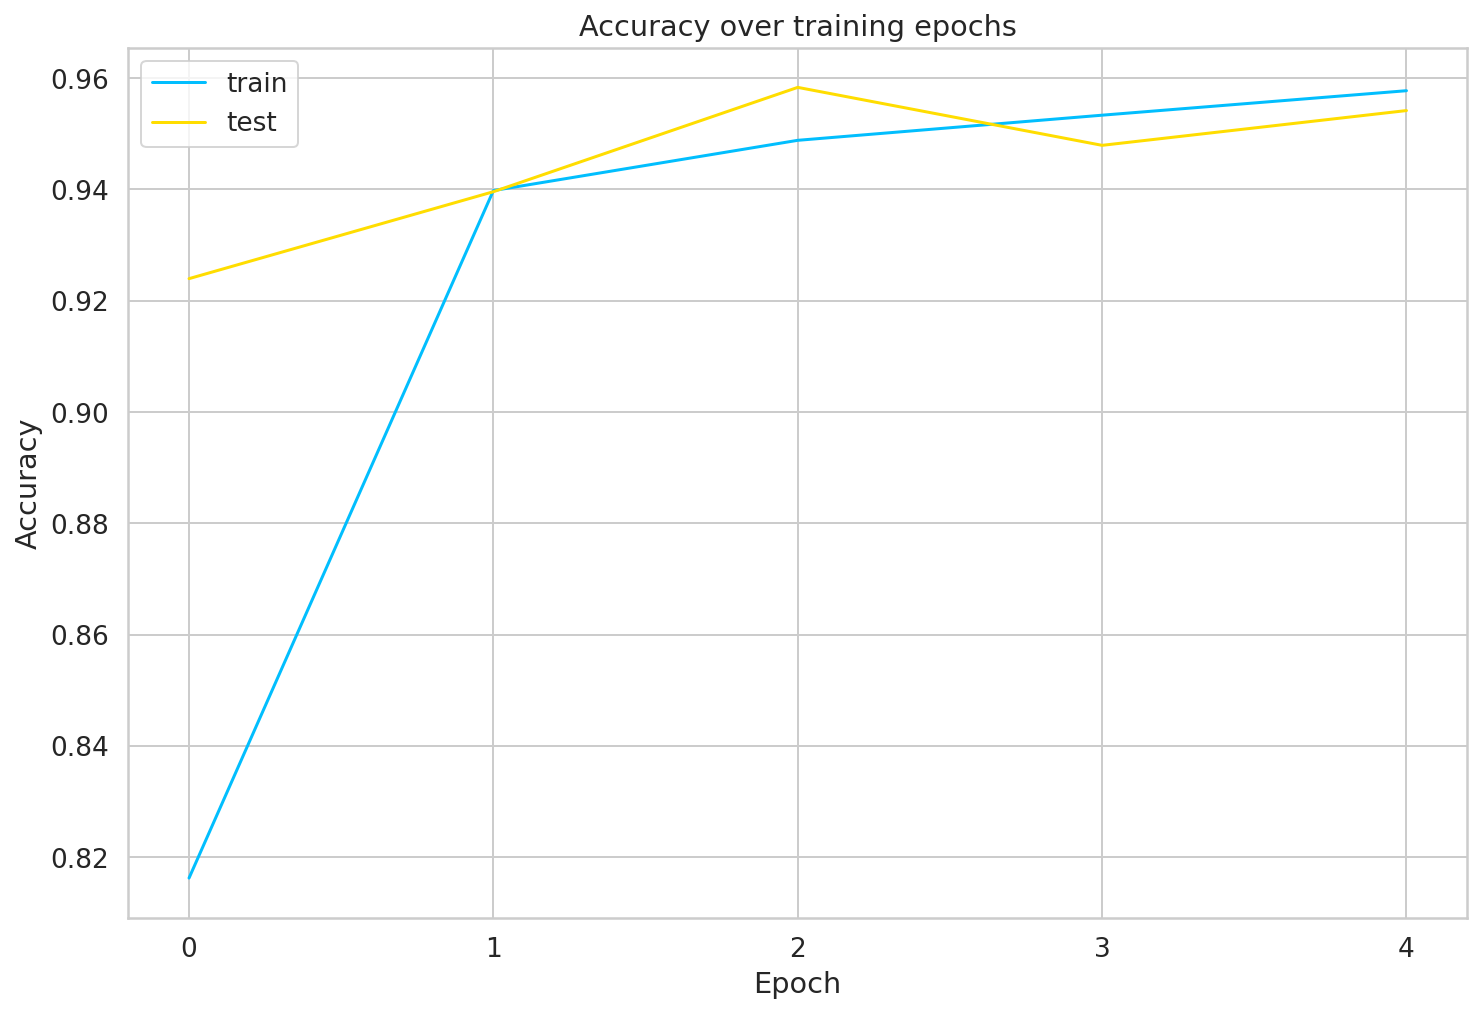

In [41]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [42]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

34/34 [==============================] - 4s 105ms/step - loss: 0.6071 - acc: 0.9438
train acc 0.9610254168510437
test acc 0.9437675476074219


In [43]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [44]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       351
           1       0.88      0.98      0.93       342
           2       0.99      0.95      0.97       374

    accuracy                           0.94      1067
   macro avg       0.95      0.94      0.94      1067
weighted avg       0.95      0.94      0.94      1067



In [45]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

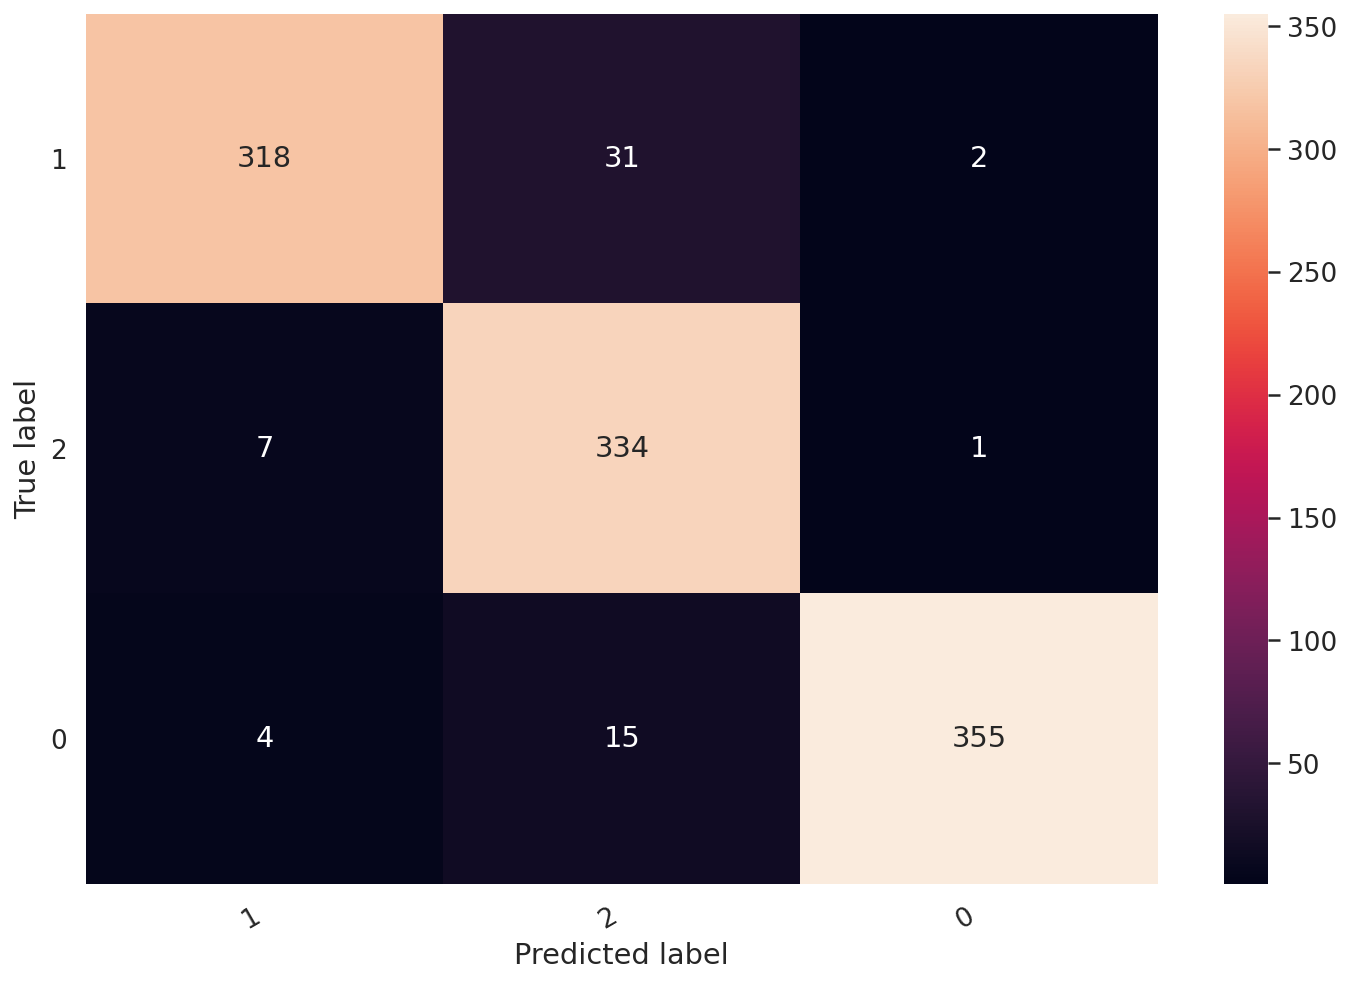

In [46]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [47]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("mBERT: ")
for i in range(kFold):
    print('\n Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=32, shuffle=True,epochs=5)
    train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


234it [00:00, 2334.94it/s]

mBERT: 

 Fold  1



9596it [00:04, 2140.35it/s]
1067it [00:00, 2337.05it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f25de710208> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 162s 601ms/step - loss: 0.7047 - acc: 0.8419 - val_loss: 0.6131 - val_acc: 0.9375
Epoch 2/5
270/270 [==============================] - 160s 593ms/step - loss: 0.6093 - acc: 0.9419 - val_loss: 0.5978 - val_acc: 0.9521
Epoch 3/5
270/270 [==============================] - 160s 592ms/step - 

226it [00:00, 2249.86it/s]


 Fold  2



9596it [00:04, 2264.63it/s]
1067it [00:00, 2306.81it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22c87d4518> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 157s 582ms/step - loss: 0.7033 - acc: 0.8438 - val_loss: 0.6221 - val_acc: 0.9292
Epoch 2/5
270/270 [==============================] - 155s 575ms/step - loss: 0.6094 - acc: 0.9420 - val_loss: 0.6225 - val_acc: 0.9281
Epoch 3/5
270/270 [==============================] - 155s 575ms/step - 

234it [00:00, 2336.05it/s]


 Fold  3



9596it [00:04, 2259.81it/s]
1067it [00:00, 2360.17it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22d4bc7f60> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 161s 597ms/step - loss: 0.7261 - acc: 0.8138 - val_loss: 0.6272 - val_acc: 0.9240
Epoch 2/5
270/270 [==============================] - 157s 582ms/step - loss: 0.6153 - acc: 0.9360 - val_loss: 0.6240 - val_acc: 0.9250
Epoch 3/5
270/270 [==============================] - 157s 582ms/step - 

232it [00:00, 2318.67it/s]


 Fold  4



9596it [00:04, 2272.64it/s]
1067it [00:00, 2304.87it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f259b6d7a90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 163s 603ms/step - loss: 0.7158 - acc: 0.8272 - val_loss: 0.6315 - val_acc: 0.9208
Epoch 2/5
270/270 [==============================] - 160s 593ms/step - loss: 0.6060 - acc: 0.9444 - val_loss: 0.6006 - val_acc: 0.9510
Epoch 3/5
270/270 [==============================] - 161s 596ms/step - 

220it [00:00, 2194.13it/s]


 Fold  5



9596it [00:04, 2257.84it/s]
1067it [00:00, 2220.26it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22c8ca30f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 163s 603ms/step - loss: 0.7037 - acc: 0.8425 - val_loss: 0.6130 - val_acc: 0.9396
Epoch 2/5
270/270 [==============================] - 160s 594ms/step - loss: 0.6068 - acc: 0.9436 - val_loss: 0.6025 - val_acc: 0.9479
Epoch 3/5
270/270 [==============================] - 160s 594ms/step - 

224it [00:00, 2239.21it/s]


 Fold  6



9596it [00:04, 2273.59it/s]
1067it [00:00, 2200.56it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22c6d4d5c0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 156s 579ms/step - loss: 0.7130 - acc: 0.8308 - val_loss: 0.6050 - val_acc: 0.9469
Epoch 2/5
270/270 [==============================] - 154s 570ms/step - loss: 0.6140 - acc: 0.9369 - val_loss: 0.5876 - val_acc: 0.9625
Epoch 3/5
270/270 [==============================] - 154s 572ms/step - 

230it [00:00, 2292.92it/s]


 Fold  7



9596it [00:04, 2273.26it/s]
1067it [00:00, 2280.55it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f259b8e15c0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 158s 585ms/step - loss: 0.7541 - acc: 0.7818 - val_loss: 0.6163 - val_acc: 0.9344
Epoch 2/5
270/270 [==============================] - 156s 577ms/step - loss: 0.6112 - acc: 0.9398 - val_loss: 0.6103 - val_acc: 0.9396
Epoch 3/5
270/270 [==============================] - 155s 575ms/step - 

227it [00:00, 2267.91it/s]


 Fold  8



9596it [00:04, 2277.02it/s]
1067it [00:00, 2231.55it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22c8e14860> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 158s 583ms/step - loss: 0.7482 - acc: 0.7903 - val_loss: 0.6101 - val_acc: 0.9417
Epoch 2/5
270/270 [==============================] - 155s 573ms/step - loss: 0.6101 - acc: 0.9413 - val_loss: 0.6091 - val_acc: 0.9417
Epoch 3/5
270/270 [==============================] - 155s 575ms/step - 

240it [00:00, 2393.32it/s]


 Fold  9



9596it [00:04, 2306.78it/s]
1067it [00:00, 2261.27it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22c488eb38> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 159s 588ms/step - loss: 0.7615 - acc: 0.7793 - val_loss: 0.6325 - val_acc: 0.9187
Epoch 2/5
270/270 [==============================] - 156s 578ms/step - loss: 0.6142 - acc: 0.9368 - val_loss: 0.6051 - val_acc: 0.9448
Epoch 3/5
270/270 [==============================] - 157s 580ms/step - 

226it [00:00, 2251.83it/s]


 Fold  10



9596it [00:04, 2259.53it/s]
1067it [00:00, 2307.52it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f22c5555e80> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
270/270 [==============================] - 159s 587ms/step - loss: 0.7185 - acc: 0.8241 - val_loss: 0.6275 - val_acc: 0.9219
Epoch 2/5
270/270 [==============================] - 156s 579ms/step - loss: 0.6078 - acc: 0.9430 - val_loss: 0.6218 - val_acc: 0.9229
Epoch 3/5
270/270 [==============================] - 154s 571ms/step - 

In [48]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.955576382380506
 Mean testing accuracy for 10 folds: 0.9555763840675354


In [49]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
print()
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful

Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 1

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 0



# Reference

1. Movie Reviews with bert-for-tf2 https://colab.research.google.com/drive/1esTDT7S7-31Uiwr8Hj1meV1aokeo8AYX?authuser=1